In [1]:
import pandas as pd
import random
# import numpy as np
# import seaborn as sns

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

In [3]:
from eventframing.eventframe import EventFrame

from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

In [4]:
from ux_researching.descriptive_stats import DescStatsAnalyzer

In [5]:
from tooling.cohorts.cohorts import Cohorts
from tooling.funnel.funnel import Funnel

# Data loading

In [6]:
data = pd.read_csv("D:/diplom/simple_shop.csv")

In [7]:
users = data['user_id'].unique()
cities = [random.choice(['NY', 'SF', 'LA']) for _ in range(len(users))]
users = pd.DataFrame({'user_id': users, 'city': cities})

data = data.merge(users, on='user_id', how='inner')

In [8]:
data.shape

(32283, 4)

In [9]:
data.head()

,user_id,event,timestamp,city
0,219483890,catalog,2019-11-01 17:59:13.273932,LA
1,219483890,product1,2019-11-01 17:59:28.459271,LA
2,219483890,cart,2019-11-01 17:59:29.502214,LA
3,219483890,catalog,2019-11-01 17:59:32.557029,LA
4,964964743,catalog,2019-11-01 21:38:19.283663,SF


In [10]:
data.event.value_counts()

event
catalog             14518
main                 5635
cart                 2842
product2             2172
delivery_choice      1686
product1             1515
payment_choice       1107
delivery_courier      834
payment_done          706
payment_card          565
delivery_pickup       506
payment_cash          197
Name: count, dtype: int64

# EDA

In [11]:
cols_schema = {
    'user_id': 'user_id',
    'event_name': 'event',
    'event_timestamp': 'timestamp'
}

ef = EventFrame(data, cols_schema=cols_schema, prepare=True)

In [12]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,event_id,event_type,event_type_index
17280,122915,main,2020-04-07 03:27:32.806542,SF,17280,raw,2
17281,122915,catalog,2020-04-07 03:27:49.914239,SF,17281,raw,2
17282,122915,main,2020-04-07 03:27:57.320839,SF,17282,raw,2
17283,122915,main,2020-04-07 03:28:00.580589,SF,17283,raw,2
17284,122915,catalog,2020-04-07 03:28:01.815559,SF,17284,raw,2


Применение препроцессоров для извлечения дополнительной информации о действиях пользователей

In [13]:
start_end_events_preprocessor = AddStartEndEventsPreprocessor()
split_sessions_preprocessor = SplitSessionsPreprocessor(timeout=(15, 'm'))

In [14]:
ef = start_end_events_preprocessor.apply(ef)

In [15]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,event_id,event_type,event_type_index
32283,122915,path_start,2020-04-07 03:27:32.806542,SF,122915_path_start,path_start,0
0,122915,main,2020-04-07 03:27:32.806542,SF,17280,raw,2
1,122915,catalog,2020-04-07 03:27:49.914239,SF,17281,raw,2
2,122915,main,2020-04-07 03:27:57.320839,SF,17282,raw,2
3,122915,main,2020-04-07 03:28:00.580589,SF,17283,raw,2


In [16]:
ef = split_sessions_preprocessor.apply(ef)

In [17]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,event_id,event_type,event_type_index,session_id
32283,122915,path_start,2020-04-07 03:27:32.806542,SF,122915_path_start,path_start,0,122915_1
32283,122915,session_start,2020-04-07 03:27:32.806542,SF,122915_1session_start,session_start,1,122915_1
0,122915,main,2020-04-07 03:27:32.806542,SF,17280,raw,2,122915_1
1,122915,catalog,2020-04-07 03:27:49.914239,SF,17281,raw,2,122915_1
2,122915,main,2020-04-07 03:27:57.320839,SF,17282,raw,2,122915_1


Изучение базовых статистик по поведению пользователей

In [18]:
desc_stats_analyzer = DescStatsAnalyzer()

In [19]:
desc_stats_analyzer.describe(
    ef,
    add_path_stats=True,
    add_session_stats=True
)

value
category             metric                                     
overall              unique_users                           3751
                     unique_events                            12
                     unique_sessions                        6456
                     frame_start      2019-11-01 17:59:13.273932
                     frame_end        2020-04-29 12:48:06.595390
                     frame_duration     179 days 18:48:53.321458
path_duration        mean              9 days 11:15:17.575685977
                     median               0 days 00:01:20.849291
                     std              23 days 02:52:24.851865733
                     min                         0 days 00:00:00
                     max                149 days 04:51:04.723411
path_steps_length    mean                               8.606505
                     median                                  6.0
                     std                                9.098354
                     min                                       1
                     max                                     100
session_duration     mean              0 days 00:00:51.218505473
                     median            0 days 00:00:30.258548500
                     std               0 days 00:01:04.415111612
                     min                         0 days 00:00:00
                     max                  0 days 00:12:08.677025
session_steps_length mean                               5.000465
                     median                                  4.0
                     std                                4.179011
                     min                                       1
                     max                                      53

In [20]:
desc_stats_analyzer.describe_events(ef, events=['catalog', 'cart', 'payment_done'])

event     overall                                                \
                event_count unique_users unique_sessions event_percentage   
0          cart        2842         1924            2457        15.731208   
1       catalog       14518         3611            5542        80.360899   
2  payment_done         706          653             706         3.907893   

                                      time_to_first_occurrence  \
  user_percentage session_percentage                      mean   
0       53.281639          44.334175 3 days 08:59:13.851574610   
1      100.000000         100.000000 0 days 05:44:21.331283847   
2       18.083633          12.739083 7 days 01:37:54.228716690   

                                                                            \
                  median                        std                    min   
0 0 days 00:00:56.002996 11 days 19:28:46.397778860 0 days 00:00:00.890726   
1        0 days 00:00:00  3 days 03:22:31.792422123        0 days 00:00:00   
2 0 days 00:01:34.083054 17 days 09:09:59.995092046 0 days 00:00:08.051634   

                           steps_to_first_occurrence                           
                       max                      mean median       std min max  
0 118 days 16:11:35.960269                  5.507277    4.0  4.088904   2  42  
1 100 days 08:19:50.980973                  1.299086    1.0  0.565143   1   8  
2 115 days 09:18:59.005470                 13.212864   11.0  8.292525   6  85

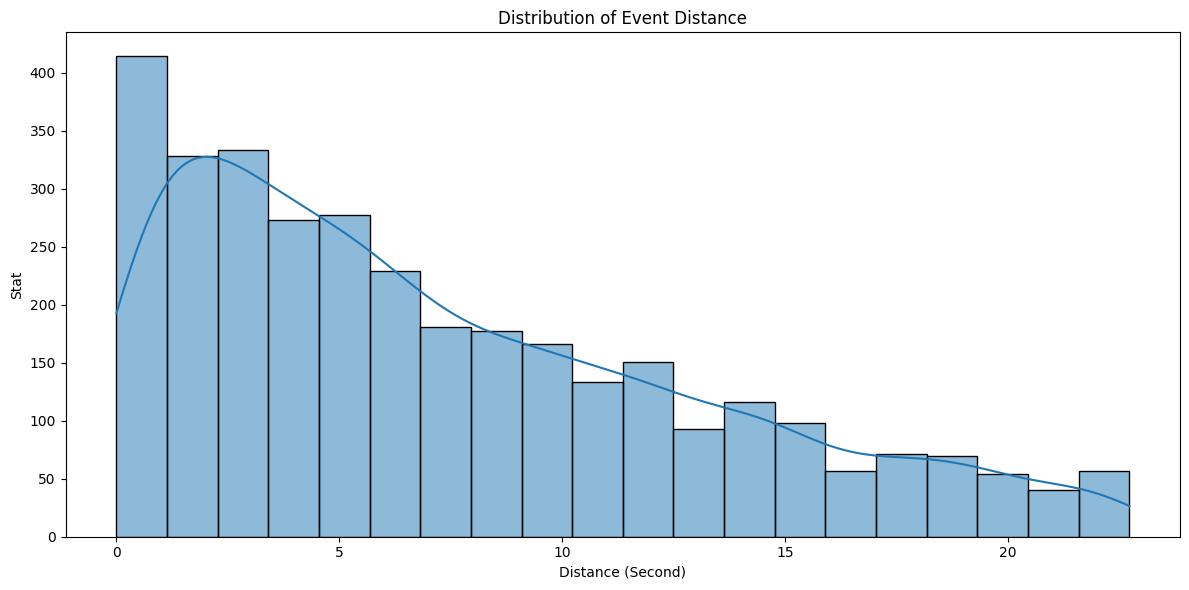

In [21]:
desc_stats_analyzer.plot_event_distance_hist(ef, event_from='catalog', event_to=['product1', 'product2'], plot_period='s', upper_cutoff_quantile=0.9)

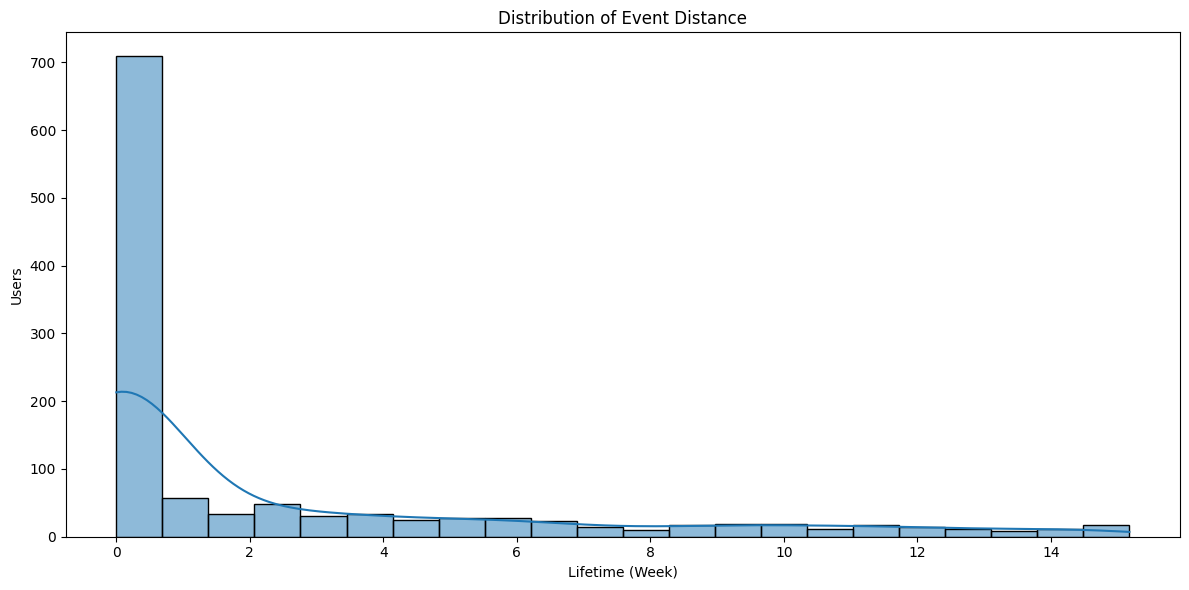

In [22]:
desc_stats_analyzer.plot_lifetime_hist(ef, max_return_time=(1, 'M'), plot_period='W')

# Воронка в покупку

In [23]:
funnel = Funnel()

In [24]:
funnel.plot(ef, stages=['catalog', 'cart', 'payment_done'])

In [25]:
data['city'].unique()

array(['LA', 'SF', 'NY'], dtype=object)

In [26]:
ny_users = ef.filter(conditions=['city == "NY"']).to_dataframe().index
la_users = ef.filter(conditions=['city == "LA"']).to_dataframe().index
funnel.plot(
    ef, 
    stages=[['product1', 'product2'], 'cart', 'payment_done'],
    stages_names=['product', 'cart', 'payment'],
    funnel_type='closed',
    segments=[ny_users, la_users],
    segments_names=['NY', 'LA']
)

In [27]:
cohorts = Cohorts()

In [28]:
_ = cohorts.fit(ef, normalize=True, cohort_period='W', represent_by='period')

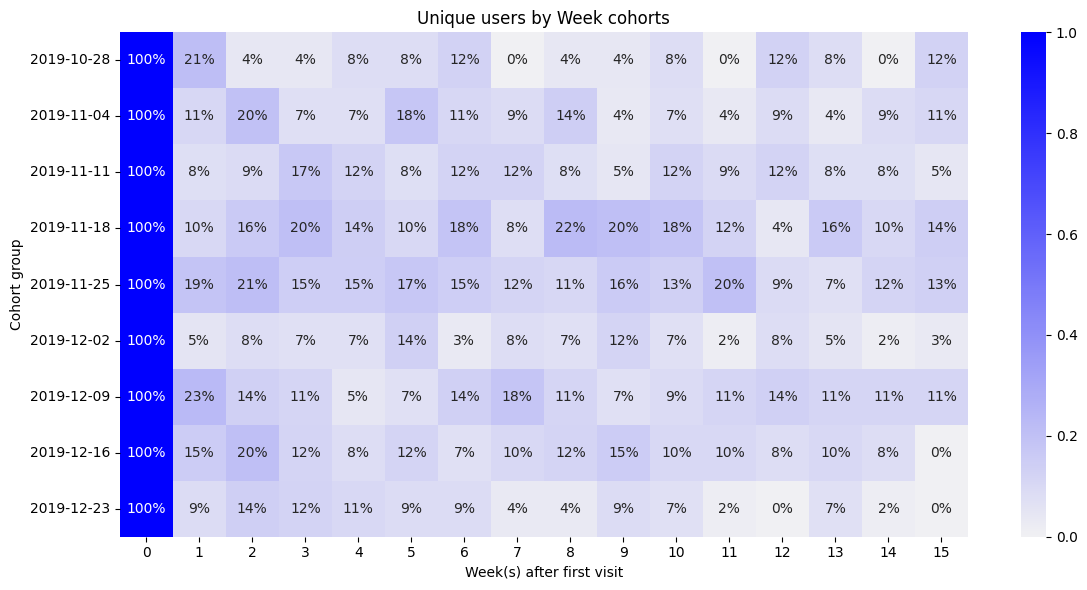

In [29]:
cohorts.plot(min_cohort='2019-10-28', max_cohort='2019-12-23', max_period=15)

In [30]:
data.event.unique()

array(['catalog', 'product1', 'cart', 'delivery_choice', 'main',
       'product2', 'delivery_courier', 'payment_choice', 'payment_cash',
       'payment_done', 'delivery_pickup', 'payment_card'], dtype=object)

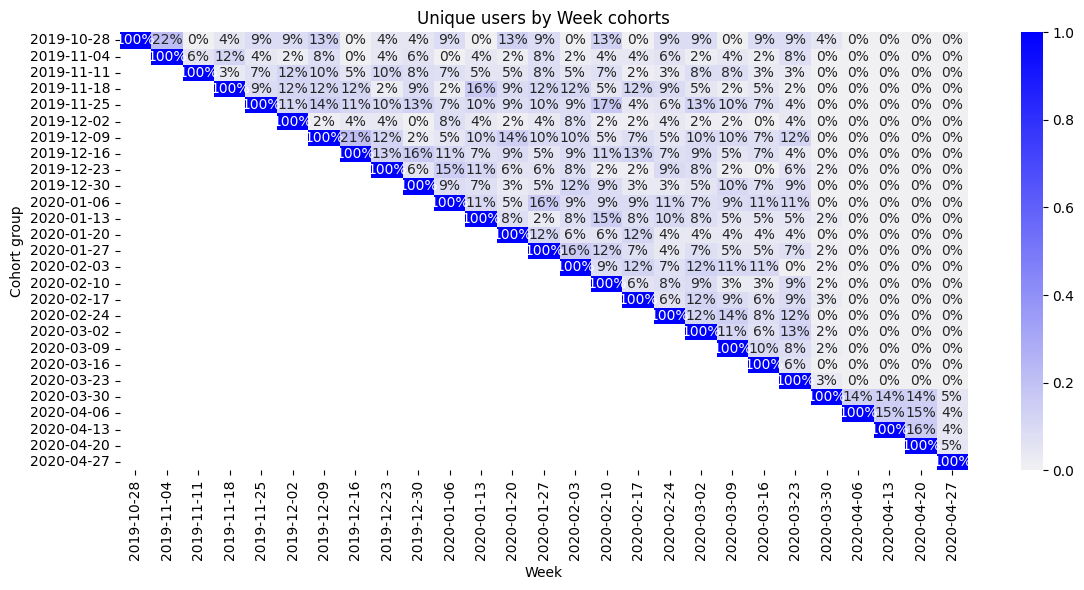

In [31]:
_ = cohorts.fit(
    ef.filter(conditions=['event.isin(["catalog"])']), 
    normalize=True, 
    cohort_period='W', 
    represent_by='time_unit'
)
cohorts.plot()

## Кластеризация


In [32]:
from clustering.clustering_data_preprocessor import ClusteringDataPreprocessor
from clustering.estimators_lib.kmeans_estimator import KMeansEstimator
from clustering.estimators_lib.dbscan_estimator import DBScanEstimator

In [33]:
clustering_preprocessor = ClusteringDataPreprocessor()
cluster_matrix = clustering_preprocessor.create_cluster_matrix(
    ef, add_session_stats=True,
    add_path_stats=True,
    preprocess=True
)

In [34]:
cluster_matrix.head()

,cart,catalog,delivery_choice,delivery_courier,delivery_pickup,main,payment_card,payment_cash,payment_choice,payment_done,...,max_gap,mean_gap,median_gap,min_amount_of_steps,max_amount_of_steps,mean_amount_of_steps,median_amount_of_steps,lifetime,amount_of_active_days,user_id
0,0.239239,3.475441,-0.638274,-0.465821,-0.363095,2.646944,-0.385087,-0.225952,-0.530626,-0.438485,...,0.009287,0.070215,0.136705,0.744412,4.068827,2.976598,2.977932,-0.147580,0.212429,122915
1,-0.747984,1.015747,-0.638274,-0.465821,-0.363095,-0.241821,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,1.554085,0.821557,1.336512,1.352088,-0.409530,-0.488999,463458
2,0.239239,0.277839,0.781753,1.629257,-0.363095,0.239639,-0.385087,-0.225952,1.267368,-0.438485,...,1.402066,1.681001,1.852830,-0.335151,1.038042,0.516468,0.539167,0.608883,0.212429,1475907
3,-0.747984,-0.952008,-0.638274,-0.465821,-0.363095,-0.241821,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,-0.874933,-1.126805,-1.123619,-1.086677,-0.409616,-0.488999,1576626
4,-0.747984,-0.214100,-0.638274,-0.465821,-0.363095,0.239639,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,0.204631,-0.260867,-0.030228,-0.002781,-0.409592,-0.488999,2112338


In [35]:
cluster_matrix.columns

Index(['cart', 'catalog', 'delivery_choice', 'delivery_courier',
       'delivery_pickup', 'main', 'payment_card', 'payment_cash',
       'payment_choice', 'payment_done', 'product1', 'product2',
       'amount_of_sessions', 'min_duration', 'max_duration', 'mean_duration',
       'median_duration', 'min_gap', 'max_gap', 'mean_gap', 'median_gap',
       'min_amount_of_steps', 'max_amount_of_steps', 'mean_amount_of_steps',
       'median_amount_of_steps', 'lifetime', 'amount_of_active_days',
       'user_id'],
      dtype='object')

In [36]:
users_clusters = cluster_matrix.user_id.to_frame()
cluster_matrix = cluster_matrix.drop(columns=['user_id'])

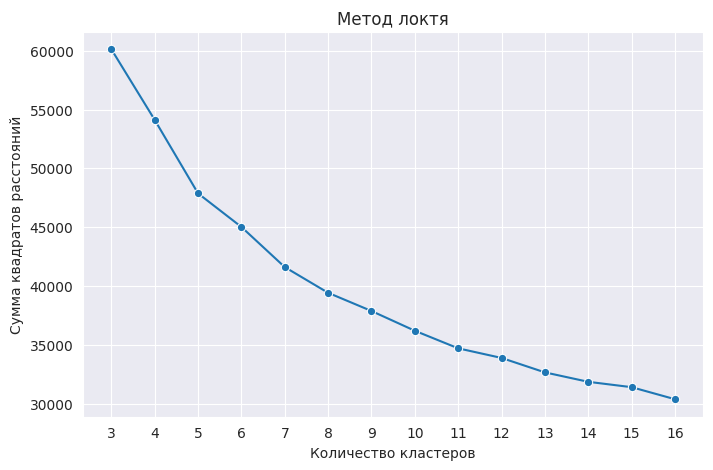

In [37]:
n_clusters_range = (3, 16)
KMeansEstimator.choose_optimal_n_clusters(n_clusters_range, cluster_matrix, method='elbow')

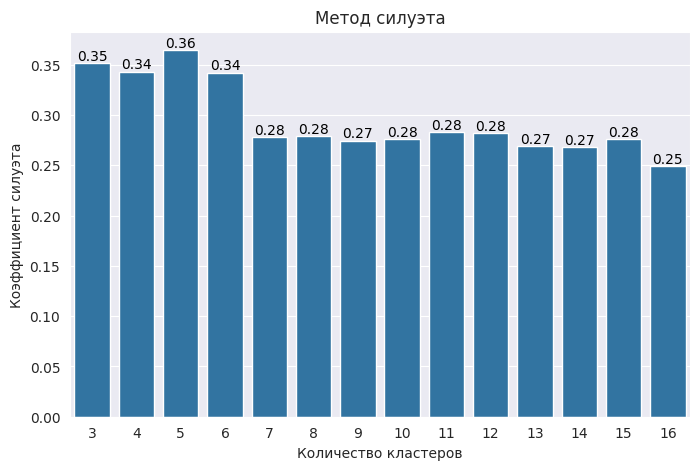

In [38]:
KMeansEstimator.choose_optimal_n_clusters(n_clusters_range, cluster_matrix, method='silhouette')

In [39]:
kmeans = KMeansEstimator(8)

In [40]:
kmeans.fit(cluster_matrix)

KMeans(max_iter=1000)

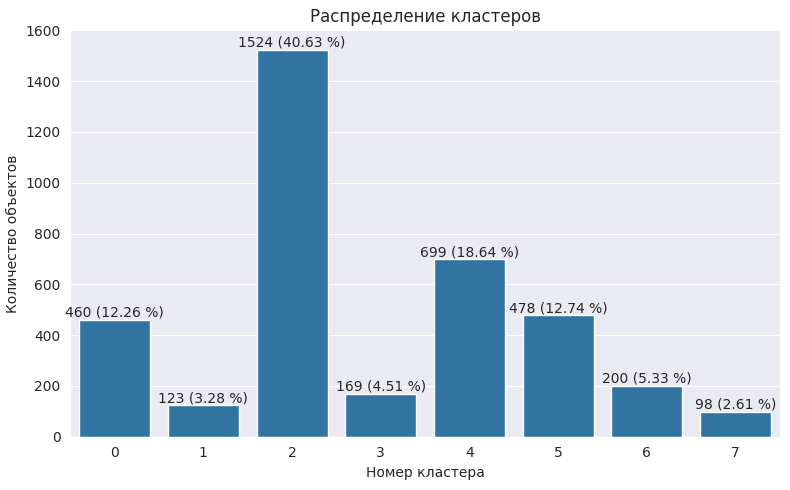

In [41]:
kmeans.plot_clusters_counts()

In [42]:
kmeans.describe_by_centroids()

,cluster,cart,catalog,delivery_choice,delivery_courier,delivery_pickup,main,payment_card,payment_cash,payment_choice,...,min_gap,max_gap,mean_gap,median_gap,min_amount_of_steps,max_amount_of_steps,mean_amount_of_steps,median_amount_of_steps,lifetime,amount_of_active_days
0,0,0.142663,0.454830,-0.141264,-0.215323,-0.134891,0.616435,-0.379529,-0.225952,-0.350827,...,0.0,0.650965,0.741438,0.737385,-0.559864,0.186221,-0.182008,-0.221622,0.333052,0.618038
1,1,0.648576,0.023870,1.081921,1.220461,0.621651,0.016523,-0.177236,4.111282,1.515871,...,0.0,0.116972,0.161697,0.163489,0.500852,0.779316,0.754814,0.745151,-0.021855,0.069863
2,2,-0.557785,-0.573383,-0.550802,-0.434244,-0.320763,-0.453841,-0.385087,-0.225952,-0.514131,...,0.0,-0.415552,-0.422140,-0.390016,-0.531644,-0.807611,-0.748318,-0.714754,-0.377245,-0.403044
3,3,0.192507,0.395729,0.109551,-0.044326,0.035076,1.552974,0.008231,0.104991,-0.030592,...,0.0,3.142748,3.114990,2.837491,-0.740786,0.065782,-0.491434,-0.616882,3.089238,2.059385
4,4,-0.100694,0.042103,-0.202283,-0.252406,-0.096634,-0.266689,-0.385087,-0.225952,-0.350053,...,0.0,-0.450013,-0.461087,-0.429575,0.569777,0.144149,0.410515,0.434393,-0.396986,-0.427611
5,5,0.639912,-0.033483,1.069917,1.063849,0.718066,-0.075627,1.802435,-0.225952,1.425350,...,0.0,-0.090493,-0.056698,-0.015604,0.608902,0.751811,0.799537,0.803054,-0.162029,-0.023826
6,6,0.634129,1.107985,0.504848,0.393161,0.161775,0.078350,0.215706,-0.075373,0.431300,...,0.0,-0.351234,-0.353325,-0.328571,2.537837,1.942948,2.534914,2.524728,-0.337333,-0.369756
7,7,3.170689,3.683762,2.882812,2.120959,1.641902,3.580389,1.493207,2.100779,2.459915,...,0.0,2.207534,1.795383,1.315395,-0.646352,1.952579,0.414047,0.139618,3.313215,3.647996


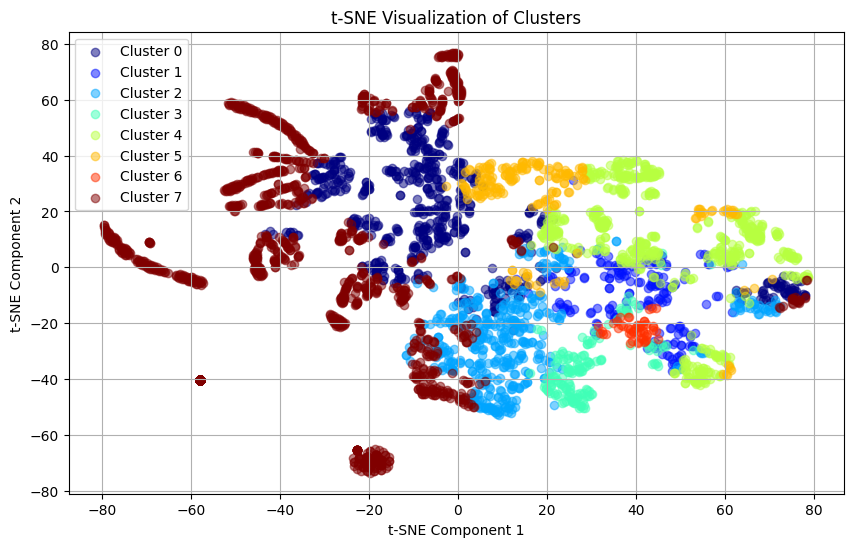

In [43]:
kmeans.plot_clusters_with_tsne(cluster_matrix)